## Hyperparam Tuning

Now that we know which models are performing better, it's time to perform cross validation and tune hyperparameters.
- Do a google search for hyperparameter ranges for each type of model.

GridSearch/RandomSearch are a great methods for checking off both of these tasks.

There is a fairly significant issue with this approach for this particular problem (described below). But in the interest of creating a basic functional pipeline, you can just use the default Sklearn methods for now.

## Preventing Data Leakage in Tuning - STRETCH

> **This step doesn't need to be part of your Minimum Viable Product (MVP), but its highly recommended you complete it, if you have time!**

BUT we have a problem - if we calculated a numerical value to encode city (such as the mean of sale prices in that city) on the training data, we can't cross validate 
- The rows in each validation fold were part of the original calculation of the mean for that city - that means we're leaking information!
- While sklearn's built in functions are extremely useful, sometimes it is necessary to do things ourselves

You need to create two functions to replicate what Gridsearch does under the hood. This is a challenging, real world data problem! To help you out, we've created some psuedocode and docstrings to get you started. 

**`custom_cross_validation()`**
- Should take the training data, and divide it into multiple train/validation splits. 
- Look into `sklearn.model_selection.KFold` to accomplish this - the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) shows how to split a dataframe and loop through the indexes of your split data. 
- Within your function, you should compute the city means on the training folds just like you did in Notebook 1 - you may have to re-join the city column to do this - and then join these values to the validation fold

This psuedocode may help you fill in the function:

```python
kfold = KFold() # fit sklearn k folds on X_train
train_folds = []
val_folds = []
for training_index, val_index in kfold.split(X_train):
    train_fold, val_fold = #.iloc loop variables on X_train

    # recompute training city means like you did in notebook 1 
    # merge to validation fold
        
    train_folds.append(train_fold)
    val_folds.append(val_fold)

    return train_folds, val_folds
```


**`hyperparameter_search()`**
- Should take the validation and training splits from your previous function, along with your dictionary of hyperparameter values
- For each set of hyperparameter values, fit your chosen model on each set of training folds, and take the average of your chosen scoring metric. [itertools.product()](https://docs.python.org/3/library/itertools.html) will be helpful for looping through all combinations of hyperparameter values
- Your function should output the hyperparameter values corresponding the highest average score across all folds. Alternatively, it could also output a model object fit on the full training dataset with these parameters.


This psuedocode may help you fill in the function:

```python
hyperparams = # Generate hyperparam options with itertools
hyperparam-scores = []
for hyperparam-combo in hyperparams:

    scores = []

    for folds in allmyfolds:
        # score fold the fold with the model/ hyperparams
        scores.append(score-fold)
        
    score = scores.mean()
    hyperparam-scores.append(score)
# After loop, find max of hyperparam-scores. Best params are at same index in `hyperparams` loop iteratble
```

Docstrings have been provided below to get you started. Once you're done developing your functions, you should move them to `functions_variables.py` to keep your notebook clean 

Bear in mind that these instructions are just one way to tackle this problem - the inputs and output formats don't need to be exactly as specified here.

In [12]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import joblib

In [13]:
# develop your custom functions here


def custom_cross_validation(training_data, n_splits =5):
    '''creates n_splits sets of training and validation folds

    Args:
      training_data: the dataframe of features and target to be divided into folds
      n_splits: the number of sets of folds to be created

    Returns:
      A tuple of lists, where the first index is a list of the training folds, 
      and the second the corresponding validation fold

    Example:
        >>> output = custom_cross_validation(train_df, n_splits = 10)
        >>> output[0][0] # The first training fold
        >>> output[1][0] # The first validation fold
        >>> output[0][1] # The second training fold
        >>> output[1][1] # The second validation fold... etc.
    '''
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    training_folds, validation_folds = [], []
    for train_idx, val_idx in kfold.split(training_data):
      train_fold, val_fold = training_data.iloc[train_idx], training_data.iloc[val_idx]
      training_folds.append(train_fold)
      validation_folds.append(val_fold)
    return training_folds, validation_folds


def hyperparameter_search(training_folds, validation_folds, param_grid):
    '''outputs the best combination of hyperparameter settings in the param grid, 
    given the training and validation folds

    Args:
      training_folds: the list of training fold dataframes
      validation_folds: the list of validation fold dataframes
      param_grid: the dictionary of possible hyperparameter values for the chosen model

    Returns:
      A list of the best hyperparameter settings based on the chosen metric

    Example:
        >>> param_grid = {
          'max_depth': [None, 10, 20, 30],
          'min_samples_split': [2, 5, 10],
          'min_samples_leaf': [1, 2, 4],
          'max_features': ['sqrt', 'log2']} # for random forest
        >>> hyperparameter_search(output[0], output[1], param_grid = param_grid) 
        # assuming 'ouput' is the output of custom_cross_validation()
        [20, 5, 2, 'log2'] # hyperparams in order
    '''
    from itertools import product
    hyperparameters, best_score = None, float('-inf')
    
    for params in product(*param_grid.values()):
        param_dict = dict(zip(param_grid.keys(), params))
        scores = []
        
        for train_fold, val_fold in zip(training_folds, validation_folds):
            X_train_fold = train_fold.drop(columns=['description_sold_price'])
            y_train_fold = train_fold['description_sold_price']
            X_val_fold = val_fold.drop(columns=['description_sold_price'])
            y_val_fold = val_fold['description_sold_price']
            
            model = XGBRegressor(objective='reg:squarederror', **param_dict)
            model.fit(X_train_fold, y_train_fold)
            score = model.score(X_val_fold, y_val_fold)
            scores.append(score)
        
        avg_score = np.mean(scores)
        if avg_score > best_score:
            best_score = avg_score
            best_params = param_dict

    return hyperparameters


In [14]:
# loading data

train = pd.read_csv(f'../processed_data/training_data_processed.csv')
test = pd.read_csv(f'../processed_data/testing_data_processed.csv')

X_train = train.drop(columns=['description_sold_price'])
y_train = train['description_sold_price']
X_test = test.drop(columns=['description_sold_price'])
y_test = test['description_sold_price']


## Hyperparam Tuning

In [48]:
# perform tuning and cross validation here 
# using GridsearchCV/ RandomsearchCV (MVP)
# or your custom functions

"""tuning_params = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_lambda': [0, 1, 10],
    'reg_alpha': [0, 1, 10]
}"""

tuning_params = {
    'n_estimators': list(range(50, 201, 25)),  # 50-200
    'learning_rate': np.linspace(0.01, 0.1, 5).tolist(),  # 0.01, 0.0325, 0.055, 0.0775, 0.1
    'max_depth': list(range(3, 7, 1)),  # 3, 4, 5, 6
    'subsample': np.linspace(0.1, 1.0, 6).tolist(),  # 0.1, 0.28, 0.46, 0.64, 0.82, 1.0
    'colsample_bytree': np.linspace(0.1, 1.0, 6).tolist(),  # 0.1, 0.28, 0.46, 0.64, 0.82, 1.0
    'reg_lambda': list(range(1, 11, 1)),  # 1-10
    'reg_alpha': list(range(1, 11, 1))  # 1-10
}

#cross validation

kf = KFold(n_splits=5, shuffle=True, random_state=42)

xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

# hyperparameter tuning using RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=tuning_params,
    n_iter=50,
    scoring='neg_mean_squared_error',
    cv=kf,
    verbose=2,
    n_jobs=1, # Changed to 1 to ensure sequential execution for full reproducibility. The R^2 and results kept changing...
    random_state=42
)

random_search.fit(X_train, y_train)

# best model
best_xgb = random_search.best_estimator_

print(f'\n\nBest parameters: {random_search.best_params_}')

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END colsample_bytree=0.28, learning_rate=0.05500000000000001, max_depth=4, n_estimators=50, reg_alpha=3, reg_lambda=7, subsample=0.45999999999999996; total time=   0.2s
[CV] END colsample_bytree=0.28, learning_rate=0.05500000000000001, max_depth=4, n_estimators=50, reg_alpha=3, reg_lambda=7, subsample=0.45999999999999996; total time=   0.0s
[CV] END colsample_bytree=0.28, learning_rate=0.05500000000000001, max_depth=4, n_estimators=50, reg_alpha=3, reg_lambda=7, subsample=0.45999999999999996; total time=   0.0s
[CV] END colsample_bytree=0.28, learning_rate=0.05500000000000001, max_depth=4, n_estimators=50, reg_alpha=3, reg_lambda=7, subsample=0.45999999999999996; total time=   0.0s
[CV] END colsample_bytree=0.28, learning_rate=0.05500000000000001, max_depth=4, n_estimators=50, reg_alpha=3, reg_lambda=7, subsample=0.45999999999999996; total time=   0.0s
[CV] END colsample_bytree=0.28, learning_rate=0.0775, max_depth=5, n

In [ ]:
"""
Best parameters: {'subsample': 0.64,
                    'reg_lambda': 2,
                    'reg_alpha': 2,
                    'n_estimators': 200,
                    'max_depth': 4,
                    'learning_rate': 0.1,
                    'colsample_bytree': 0.64}
"""

We want to make sure that we save our models.  In the old days, one just simply pickled (serialized) the model.  Now, however, certain model types have their own save format.  If the model is from sklearn, it can be pickled, if it's xgboost, for example, the newest format to save it in is JSON, but it can also be pickled.  It's a good idea to stay with the most current methods. 
- you may want to create a new `models/` subdirectory in your repo to stay organized

In [49]:
# save your best model here

joblib.dump(best_xgb, '../model/best_xgb_model.pkl')

['../model/best_xgb_model.pkl']

In [50]:
# Load the best model for predictions
loaded_model = joblib.load('../model/best_xgb_model.pkl')
y_pred = loaded_model.predict(X_test)

In [51]:
# Evaluate model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

test_mae = mean_absolute_error(y_test, y_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_r2 = r2_score(y_test, y_pred)

print(f"Test MAE: {test_mae:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test R² Score: {test_r2:.4f}")

Test MAE: 0.2536
Test RMSE: 0.3525
Test R² Score: 0.7945


#### Visualization

In [105]:
# Imports
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import xgboost as xgb

In [113]:
plt.figure(figsize=(8,5))

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

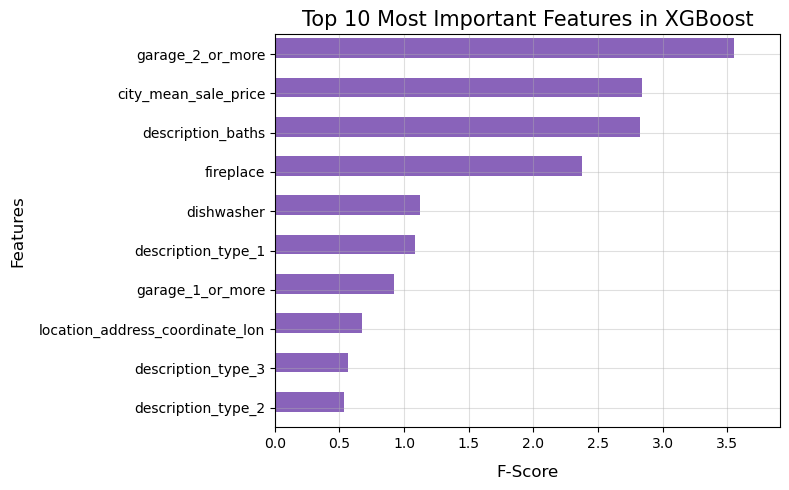

In [120]:
# Plot feature importance
fig, ax = plt.subplots(figsize=(8, 5))
xgb.plot_importance(loaded_model.get_booster(),
                    importance_type='gain',
                    max_num_features=10,
                    ax=ax,
                    color='#8963BA')

# Adjust bar thickness
for patch in ax.patches:
    patch.set_height(patch.get_height() * 2.5)
    
# Remove numbers at the end of bars
for text in ax.texts:
    if text.get_position()[0] > 0:
        text.set_visible(False)

ax.grid(alpha=0.4)
ax.set_ylim(-0.5, len(ax.patches) - 0.5)

plt.title("Top 10 Most Important Features in XGBoost",
          fontdict={'fontsize': 15})
plt.xlabel("F-Score",
           fontdict={'fontsize': 12},
           labelpad=10)
plt.ylabel("Features",
           fontdict={'fontsize': 12},
           labelpad=10)

plt.tight_layout()
plt.savefig('../images/feature_importance_xgb.png',
            dpi=300,
            bbox_inches='tight')
plt.show()

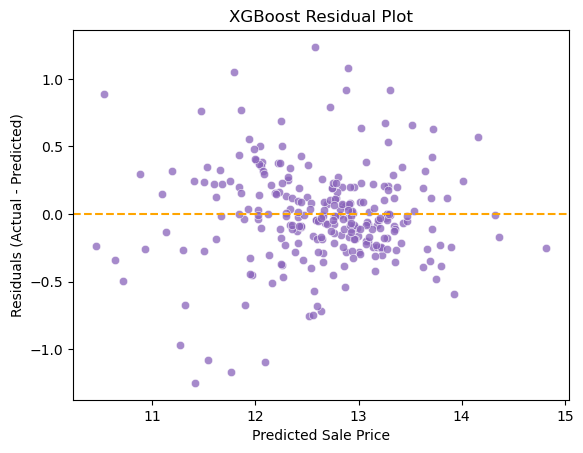

In [123]:
# Residuals plot
residuals = y_test - y_pred

sns.scatterplot(x=y_pred,
                y=residuals,
                alpha=0.75,
                color='#8963BA')
plt.axhline(y=0, color='orange', linestyle='--')

plt.xlabel("Predicted Sale Price")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("XGBoost Residual Plot")

plt.savefig('../images/residual_plot_xgb.png',
            dpi=300,
            bbox_inches='tight')
plt.show()

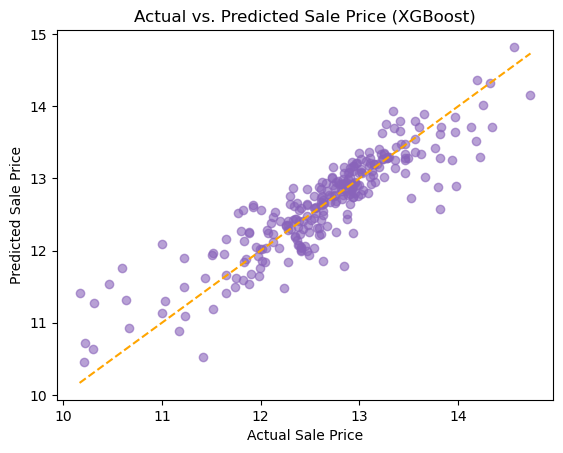

In [127]:
# Actual vs. Predicted plot
plt.scatter(y_test,
            y_pred,
            alpha=0.6,
            color='#8963BA')
plt.plot([y_test.min(),
          y_test.max()],
         [y_test.min(),
          y_test.max()],
         color='orange', linestyle="--")

plt.xlabel("Actual Sale Price")
plt.ylabel("Predicted Sale Price")
plt.title("Actual vs. Predicted Sale Price (XGBoost)")

plt.savefig('../images/actual_vs_predicted_xgb.png',
            dpi=300,
            bbox_inches='tight')
plt.show()

## Building a Pipeline (Stretch)

> **This step doesn't need to be part of your Minimum Viable Product (MVP), but its highly recommended you complete it if you have time!**

Once you've identified which model works the best, implement a prediction pipeline to make sure that you haven't leaked any data, and that the model could be easily deployed if desired.
- Your pipeline should load the data, process it, load your saved tuned model, and output a set of predictions
- Assume that the new data is in the same JSON format as your original data - you can use your original data to check that the pipeline works correctly
- Beware that a pipeline can only handle functions with fit and transform methods.
- Classes can be used to get around this, but now sklearn has a wrapper for user defined functions.
- You can develop your functions or classes in the notebook here, but once they are working, you should import them from `functions_variables.py` 

Pipelines come from sklearn.  When a pipeline is pickled, all of the information in the pipeline is stored with it.  For example, if we were deploying a model, and we had fit a scaler on the training data, we would want the same, already fitted scaling object to transform the new data with.  This is all stored when the pipeline is pickled.
- save your final pipeline in your `models/` folder

In [ ]:
# save your pipeline here